In [4]:
import numpy as np
import os
import datetime
import os
import cv2
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt


In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [6]:
basePath = "Project_data/"
train_path = basePath+'train'
val_path = basePath+'val'
print(train_path)

Project_data/train


In [7]:
train_doc = np.random.permutation(open(basePath+'train.csv').readlines())
val_doc = np.random.permutation(open(basePath+'val.csv').readlines()) 

In [20]:
import numpy as np
import cv2
import os

class VideoDataGenerator:
    def __init__(self, source_path,train_doc, batch_size, image_height, image_width, frames_to_sample):
        self.source_path = source_path
        self.batch_size = batch_size
        self.image_height = image_height
        self.image_width = image_width
        self.frames_to_sample = frames_to_sample
        self.train_doc = train_doc
        

    def augment_image(self, image):
        """Apply transformations to the image for augmentation."""
        shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30, 30)],
                                                    [0, 1, np.random.randint(-30, 30)]]),
                                 (image.shape[1], image.shape[0]))
        gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
        x0, y0 = np.argwhere(gray > 0).min(axis=0)
        x1, y1 = np.argwhere(gray > 0).max(axis=0)
        cropped = shifted[x0:x1, y0:y1, :]
        resized = cv2.resize(cropped, (self.image_height, self.image_width))
        return resized / 255.0

    def process_image(self, image_path):
        """Load and process an individual image."""
        image = cv2.imread(image_path).astype(np.float32)
        image_resized = cv2.resize(image, (self.image_height, self.image_width))
        return image_resized / 255.0

    def generator(self):
        """Generator function to yield batches of data."""
        folder_list = os.listdir(self.source_path)
        img_idx = [i for i in range(self.frames_to_sample)]
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // self.batch_size
            for batch in range(num_batches):
                batch_data, batch_labels = self.create_batch(t, batch, self.batch_size, img_idx)
                yield batch_data, batch_labels

            # Handle remaining data for last batch if not evenly divisible
            remaining_data_size = len(t) % self.batch_size
            if remaining_data_size:
                for batch in range(remaining_data_size):
                    batch_data, batch_labels = self.create_batch(t, batch, self.batch_size, img_idx)
                    yield batch_data, batch_labels
            

    def create_batch(self, shuffled_folders, batch_index, size, img_idx):
        x, y, z = len(img_idx), self.image_height, self.image_width
        batch_data = np.zeros((size, x, y, z, 3))  # Initialize batch data
        batch_labels = np.zeros((size, 5))  # Initialize batch labels

        for folder_idx in range(size):  
            actual_idx = folder_idx + (batch_index * self.batch_size)
            if actual_idx < len(shuffled_folders):
                selectedFolder = shuffled_folders[actual_idx]
                imgs = os.listdir(self.source_path + '/' + selectedFolder.split(';')[0])

                folder_elements = None
                for record in self.train_doc:
                    if record.startswith(selectedFolder):
                        folder_elements = record.split(';')
                        break

                for idx, img_num in enumerate(img_idx):
                    if img_num >= len(imgs):
                        continue
                    image_path = os.path.join(self.source_path, folder_elements[0], imgs[img_num])
                    image = self.process_image(image_path)
                    
                    batch_data[folder_idx, idx] = image                    
                    label_index = int(folder_elements[2])
        
                batch_labels[folder_idx, label_index] = 1

        return batch_data, batch_labels 

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D,Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.layers import LSTM

In [9]:
def set_callbacks(model_number,checkPoint,bestModel,lr,earlyStop,monitoringMetric):
    model_number_str = str(model_number)
    curr_dt_time = datetime.datetime.now()
    
    parent_model_folder = 'models'
    if not os.path.exists(parent_model_folder):
        os.mkdir(parent_model_folder)
    
    model_folder = parent_model_folder + '/model-number-' + model_number_str
    if not os.path.exists(model_folder):
        os.mkdir(model_folder)
    
    model_name = model_folder + '/models-model_init-' + model_number_str \
                 + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/' 
        
    if not os.path.exists(model_name):
        os.mkdir(model_name)
    
    callbackList = []
    
    if checkPoint:
        epoch_filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5' 
        # Callback to save the model checkpoints after each epoch
        epoch_checkpoint = ModelCheckpoint(epoch_filepath, monitor=monitoringMetric, verbose=1, 
                                       save_best_only=False, save_weights_only=False, mode='auto')
        callbackList.append(epoch_checkpoint)
    
    if bestModel:
        # Filepath for saving the best model based on validation categorical accuracy
        best_model_filepath = model_folder+"/best_model.h5" 
        # Callback to save the best model
        best_model_checkpoint = ModelCheckpoint(best_model_filepath, monitor=monitoringMetric, 
                                            verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        callbackList.append(best_model_checkpoint)
    
    if lr:
        LR=ReduceLROnPlateau(monitor=monitoringMetric,factor=0.2, 
                                   patience=4, 
                                   verbose=1)
        callbackList.append(LR)
    
    if earlyStop:
        # early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=10, verbose=1, restore_best_weights=True)
        earlystop = EarlyStopping( monitor=monitoringMetric, min_delta=0,patience=10,verbose=1)
        callbackList.append(earlystop)
          
    
    return callbackList


In [30]:
def create_model(input_shape, num_classes,denseNeurons=64):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(denseNeurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(denseNeurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(num_classes,activation='softmax'))

  
        return model

In [31]:
def get_sequence(trainDoc,valDoc,batchSize , epochs):
    
    num_train_sequences = len(trainDoc)  
    num_val_sequences = len(valDoc)
    num_epochs = epochs
    
    if (num_train_sequences%batchSize) == 0:
        steps_per_epoch = int(num_train_sequences/batchSize)
    else:
        steps_per_epoch = (num_train_sequences//batchSize) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batchSize)
    else:
        validation_steps = (num_val_sequences//batchSize) + 1 
    
    print('training sequences =', num_train_sequences)
    print('validation sequences =', num_val_sequences) 
    print ('epochs =', num_epochs)
    print("validation_steps",validation_steps)
    print("steps_per_epoch",steps_per_epoch) 
    return steps_per_epoch,validation_steps

In [32]:
def plot_model(loss,val_loss,acc , val_acc):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(loss)   
        axes[0].plot(val_loss)
        axes[0].legend(['Loss','Validation Loss'])

        axes[1].plot(acc)   
        axes[1].plot(val_acc)
        axes[1].legend(['Accuracy','Validation Accuraccy'])

In [15]:
batch_size = 20
imageHeight = 100
imageWidth = 100
framesToSample = 30

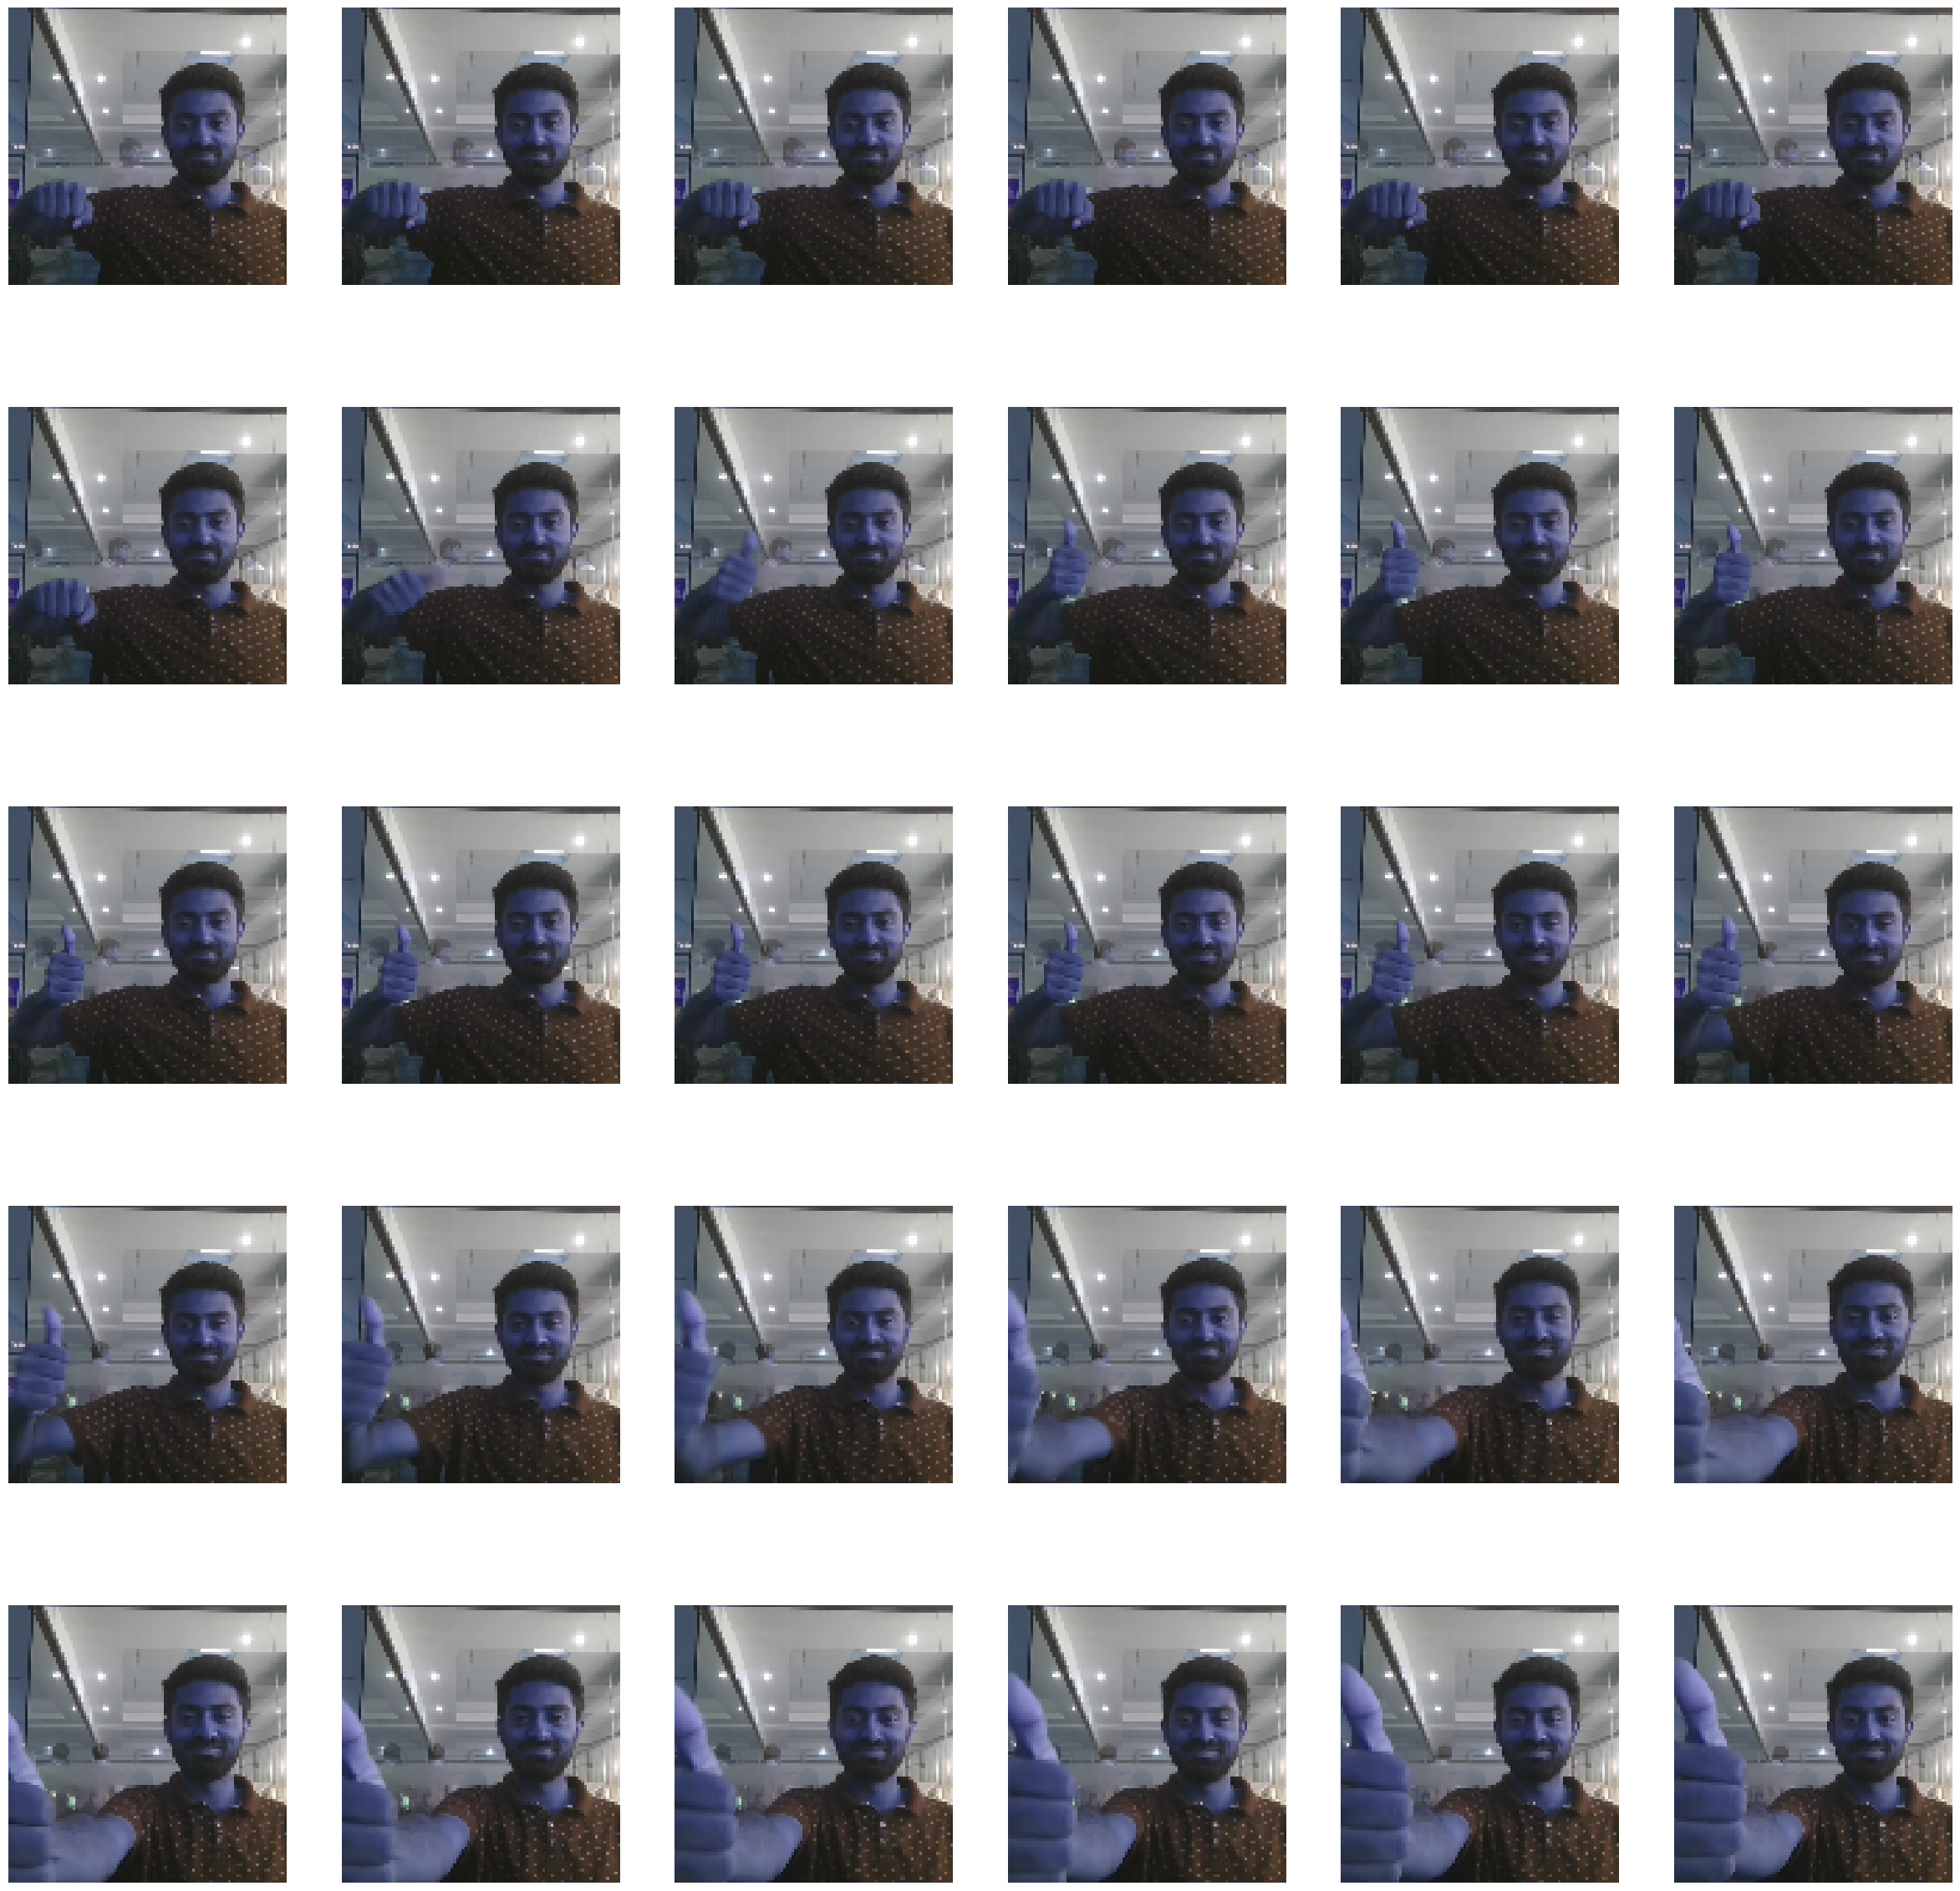

In [61]:
train_data_generator = VideoDataGenerator(train_path,train_doc, batch_size, imageHeight, imageWidth, framesToSample)
val_data_generator = VideoDataGenerator(val_path,val_doc, batch_size, imageHeight, imageWidth, framesToSample)

# Use the generator method of the instances to get the generators
train_generator = train_data_generator.generator()
val_generator = val_data_generator.generator()

x_batch, y_batch = next(train_generator)
# Assuming you want to visualize the first frame of the first sample in the batch
num_rows = 5
num_columns = 6
plt.figure(figsize=(30, 30))
# Iterate over samples and frames to visualize all frames
for sample_index in range(x_batch.shape[0]):  # Iterate over samples
    for frame_index in range(x_batch.shape[1]):  # Iterate over frames
        plt.subplot(num_rows, num_columns, frame_index + 1)
        image_to_visualize = x_batch[sample_index, frame_index]
        plt.imshow(image_to_visualize)
        plt.axis('off')  # Turn off axis labels 
    break; 
    
plt.show()


### Model 1  Conv3d - Batch Size - 24 , Image Size (100 x 100 ) , 30 Frames  

In [10]:
model_number = 1
batch_size = 24
imageHeight = 100
imageWidth = 100
framesToSample = 30
rgbChannels = 3
input_shape = (framesToSample, imageWidth, imageHeight, rgbChannels)
num_classes = 5 

In [11]:
model=create_model(input_shape, num_classes)
optimiser = optimizers.Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
callbacks_list = set_callbacks(model_number,True,True,True,True,'val_categorical_accuracy'); 

In [12]:
train_data_generator = VideoDataGenerator(train_path,train_doc, batch_size, imageHeight, imageWidth, framesToSample)
val_data_generator = VideoDataGenerator(val_path,val_doc, batch_size, imageHeight, imageWidth, framesToSample)

# Use the generator method of the instances to get the generators
train_generator = train_data_generator.generator()
val_generator = val_data_generator.generator()


In [13]:
num_epochs = 100
steps_per_epoch ,validation_steps = get_sequence(train_doc,val_doc,batch_size,num_epochs)

training sequences = 663
validation sequences = 100
epochs = 100
validation_steps 5
steps_per_epoch 28


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 100, 100, 16   1312      
                             )                                   
                                                                 
 activation (Activation)     (None, 30, 100, 100, 16   0         
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 30, 100, 100, 16   64        
 Normalization)              )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 15, 50, 50, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 50, 50, 32)    1

In [15]:
history=model.fit(train_generator, epochs=num_epochs, verbose=1,steps_per_epoch=steps_per_epoch,   
                    callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0
                   )

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 1.7072 - categorical_accuracy: 0.3824
Epoch 1: saving model to models/model-number-1/models-model_init-1_2023-11-1023_27_11.105753\model-00001-1.70725-0.38244-2.13615-0.20000.h5

Epoch 1: val_categorical_accuracy improved from -inf to 0.20000, saving model to models/model-number-1\best_model.h5
28/28 [==============================] - 226s 8s/step - loss: 1.7072 - categorical_accuracy: 0.3824 - val_loss: 2.1361 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 1.2737 - categorical_accuracy: 0.4881
Epoch 2: saving model to models/model-number-1/models-model_init-1_2023-11-1023_27_11.105753\model-00002-1.27374-0.48810-1.58958-0.28333.h5

Epoch 2: val_categorical_accuracy improved from 0.20000 to 0.28333, saving model to models/model-number-1\best_model.h5
28/28 [==============================] - 218s 8s/step - loss: 1.2737 - categorical_accuracy: 0.4881 

Epoch 17/100
28/28 [==============================] - ETA: 0s - loss: 0.1990 - categorical_accuracy: 0.9405
Epoch 17: saving model to models/model-number-1/models-model_init-1_2023-11-1023_27_11.105753\model-00017-0.19904-0.94048-0.96220-0.60000.h5

Epoch 17: val_categorical_accuracy improved from 0.55833 to 0.60000, saving model to models/model-number-1\best_model.h5
28/28 [==============================] - 218s 8s/step - loss: 0.1990 - categorical_accuracy: 0.9405 - val_loss: 0.9622 - val_categorical_accuracy: 0.6000 - lr: 4.0000e-05
Epoch 18/100
28/28 [==============================] - ETA: 0s - loss: 0.1902 - categorical_accuracy: 0.9509
Epoch 18: saving model to models/model-number-1/models-model_init-1_2023-11-1023_27_11.105753\model-00018-0.19023-0.95089-0.80973-0.66667.h5

Epoch 18: val_categorical_accuracy improved from 0.60000 to 0.66667, saving model to models/model-number-1\best_model.h5
28/28 [==============================] - 218s 8s/step - loss: 0.1902 - categorical_accu

Epoch 33/100
28/28 [==============================] - ETA: 0s - loss: 0.1333 - categorical_accuracy: 0.9747
Epoch 33: saving model to models/model-number-1/models-model_init-1_2023-11-1023_27_11.105753\model-00033-0.13332-0.97470-0.60891-0.81667.h5

Epoch 33: val_categorical_accuracy did not improve from 0.82500
28/28 [==============================] - 220s 8s/step - loss: 0.1333 - categorical_accuracy: 0.9747 - val_loss: 0.6089 - val_categorical_accuracy: 0.8167 - lr: 1.6000e-06
Epoch 34/100
28/28 [==============================] - ETA: 0s - loss: 0.1421 - categorical_accuracy: 0.9702
Epoch 34: saving model to models/model-number-1/models-model_init-1_2023-11-1023_27_11.105753\model-00034-0.14208-0.97024-0.49206-0.82500.h5

Epoch 34: val_categorical_accuracy did not improve from 0.82500

Epoch 34: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
28/28 [==============================] - 219s 8s/step - loss: 0.1421 - categorical_accuracy: 0.9702 - val_loss: 0.4921 - va

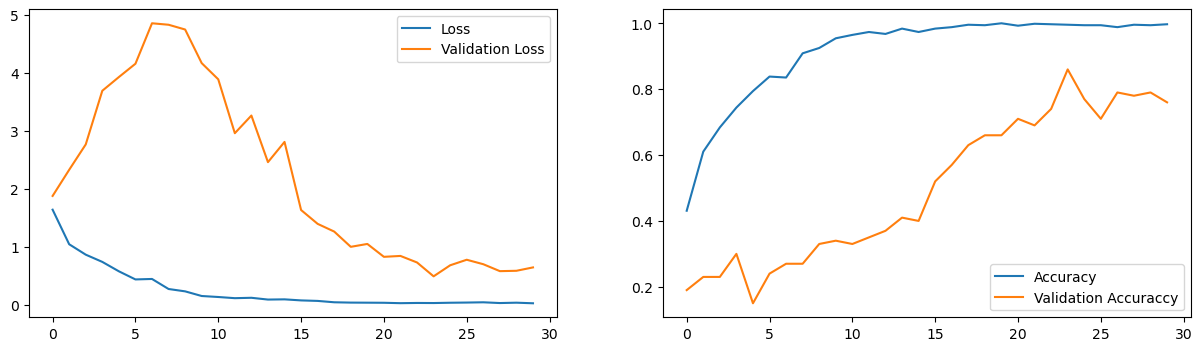

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['categorical_accuracy'] 
val_acc = history.history['val_categorical_accuracy']

plot_model(loss,val_loss,acc,val_acc)

Observations : 

 - The model displayed inconsistent validation accuracy, with some improvement over epochs but significant fluctuations, indicating potential overfitting issues.
 
 - Training stopped at epoch 48 due to early stopping, suggesting the model had reached its learning capacity under current settings.
 
 - The highest validation accuracy achieved was around 84.17% at epoch 38, indicating the peak performance of the model.
 
 - Despite the learning rate adjustments, later epochs (especially after epoch 30) did not show significant improvement in validation accuracy, suggesting the model might have reached its learning capacity with the given model layers and data.
 
 - There is a consistent gap between training and validation accuracy, with training accuracy being significantly higher. This suggests overfitting, where the model performs well on training data but less so on unseen data.
 
 - The model exhibited a significant disparity between training accuracy (peaking at 97.77%) and validation accuracy (max 84.17%), suggesting a notable overfitting issue.

Lets create another model making some changes with an increase in image size from (100 x 100 ) to (120 x 120 ) and reducing batch size to 20 and reducing frames from 30 to 20. This time we will also skip early stop callback to let it run for the full 30 epochs.

### Model 2  Conv3d - Batch Size - 20, Image Size (120 x 120 ) , 20 Frames , Without Early Stop

In [16]:
model_number = 2
batch_size = 20
imageHeight = 120
imageWidth = 120
framesToSample = 20
rgbChannels = 3
input_shape = (framesToSample, imageWidth, imageHeight, rgbChannels)
num_classes = 5 

In [17]:
model=create_model(input_shape, num_classes,128)
optimiser = optimizers.Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
callbacks_list = set_callbacks(model_number,True,True,True,False,'val_categorical_accuracy'); 


In [18]:
train_data_generator = VideoDataGenerator(train_path,train_doc, batch_size, imageHeight, imageWidth, framesToSample)
val_data_generator = VideoDataGenerator(val_path,val_doc, batch_size, imageHeight, imageWidth, framesToSample)

# Use the generator method of the instances to get the generators
train_generator = train_data_generator.generator()
val_generator = val_data_generator.generator()


In [19]:
num_epochs = 30
steps_per_epoch ,validation_steps = get_sequence(train_doc,val_doc,batch_size,num_epochs)

training sequences = 663
validation sequences = 100
epochs = 30
validation_steps 5
steps_per_epoch 34


In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_4 (Activation)   (None, 20, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_6 (Bat  (None, 20, 120, 120, 16   64        
 chNormalization)            )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 10, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 32)   

In [21]:
history=model.fit(train_generator, epochs=num_epochs, verbose=1,steps_per_epoch=steps_per_epoch,   
                    callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0
                   )

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.6382 - categorical_accuracy: 0.4309
Epoch 1: saving model to models/model-number-2/models-model_init-2_2023-11-1102_22_01.965352\model-00001-1.63822-0.43088-1.87583-0.19000.h5

Epoch 1: val_categorical_accuracy improved from -inf to 0.19000, saving model to models/model-number-2\best_model.h5
34/34 [==============================] - 214s 6s/step - loss: 1.6382 - categorical_accuracy: 0.4309 - val_loss: 1.8758 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.0419 - categorical_accuracy: 0.6103
Epoch 2: saving model to models/model-number-2/models-model_init-2_2023-11-1102_22_01.965352\model-00002-1.04188-0.61029-2.32679-0.23000.h5

Epoch 2: val_categorical_accuracy improved from 0.19000 to 0.23000, saving model to models/model-number-2\best_model.h5
34/34 [==============================] - 213s 6s/step - loss: 1.0419 - categorical_accuracy: 0.6103 - 

Epoch 17/30
34/34 [==============================] - ETA: 0s - loss: 0.0640 - categorical_accuracy: 0.9882
Epoch 17: saving model to models/model-number-2/models-model_init-2_2023-11-1102_22_01.965352\model-00017-0.06402-0.98824-1.39392-0.57000.h5

Epoch 17: val_categorical_accuracy improved from 0.52000 to 0.57000, saving model to models/model-number-2\best_model.h5
34/34 [==============================] - 214s 6s/step - loss: 0.0640 - categorical_accuracy: 0.9882 - val_loss: 1.3939 - val_categorical_accuracy: 0.5700 - lr: 2.0000e-04
Epoch 18/30
34/34 [==============================] - ETA: 0s - loss: 0.0405 - categorical_accuracy: 0.9956
Epoch 18: saving model to models/model-number-2/models-model_init-2_2023-11-1102_22_01.965352\model-00018-0.04053-0.99559-1.26071-0.63000.h5

Epoch 18: val_categorical_accuracy improved from 0.57000 to 0.63000, saving model to models/model-number-2\best_model.h5
34/34 [==============================] - 213s 6s/step - loss: 0.0405 - categorical_accura

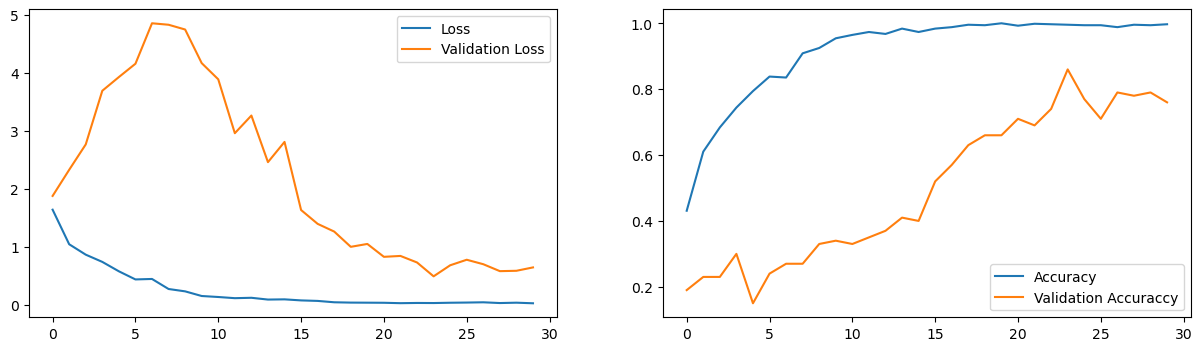

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['categorical_accuracy'] 
val_acc = history.history['val_categorical_accuracy']

plot_model(loss,val_loss,acc,val_acc)

Observation 

 - consistent improvement in training categorical accuracy, reaching a peak of 99.71% by the final epoch
 
 - There was an overall upward trend in validation accuracy, peaking at 86.00% in epoch 24, but it fluctuated and didn't consistently match training accuracy improvements.
 
 - Similar to the first model, Model 2 exhibited a significant gap between training and validation performance, indicating possible overfitting issues.

Model 2, despite running for fewer epochs, managed to reach a higher validation accuracy peak, which shows that changes made like increasing image size , reducing batch size and reduced frames have shown some positive impacts. But before drawing conclusion over the same , lets do a sample run by changing these features on the opposite sides

### Model 3  Conv3d - Batch Size -20, Image Size (100 x 100 ) , 30 Frames

In [33]:
model_number = 3
batch_size = 20
imageHeight = 100
imageWidth = 100
framesToSample = 30
num_epochs = 50
rgbChannels = 3
input_shape = (framesToSample, imageWidth, imageHeight, rgbChannels)
num_classes = 5 

In [34]:
model=create_model(input_shape, num_classes,128)
optimiser = optimizers.Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
callbacks_list = set_callbacks(model_number,True,True,True,True,'val_categorical_accuracy'); 


In [35]:
train_data_generator = VideoDataGenerator(train_path,train_doc, batch_size, imageHeight, imageWidth, framesToSample)
val_data_generator = VideoDataGenerator(val_path,val_doc, batch_size, imageHeight, imageWidth, framesToSample)

# Use the generator method of the instances to get the generators
train_generator = train_data_generator.generator()
val_generator = val_data_generator.generator()


In [36]:
steps_per_epoch ,validation_steps = get_sequence(train_doc,val_doc,batch_size,num_epochs)

training sequences = 663
validation sequences = 100
epochs = 50
validation_steps 5
steps_per_epoch 34


In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 100, 100, 16   1312      
                             )                                   
                                                                 
 activation_4 (Activation)   (None, 30, 100, 100, 16   0         
                             )                                   
                                                                 
 batch_normalization_6 (Bat  (None, 30, 100, 100, 16   64        
 chNormalization)            )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 15, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 50, 50, 32)   

In [38]:
history=model.fit(train_generator, epochs=num_epochs, verbose=1,steps_per_epoch=steps_per_epoch,   
                    callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0
                   )

Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 1.6326 - categorical_accuracy: 0.4456
Epoch 1: saving model to models/model-number-3/models-model_init-3_2023-11-1310_46_14.706348\model-00001-1.63260-0.44559-1.76581-0.25000.h5

Epoch 1: val_categorical_accuracy improved from -inf to 0.25000, saving model to models/model-number-3\best_model.h5
34/34 [==============================] - 222s 6s/step - loss: 1.6326 - categorical_accuracy: 0.4456 - val_loss: 1.7658 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 1.0012 - categorical_accuracy: 0.6176
Epoch 2: saving model to models/model-number-3/models-model_init-3_2023-11-1310_46_14.706348\model-00002-1.00124-0.61765-2.97226-0.16000.h5

Epoch 2: val_categorical_accuracy did not improve from 0.25000
34/34 [==============================] - 221s 7s/step - loss: 1.0012 - categorical_accuracy: 0.6176 - val_loss: 2.9723 - val_categorical_accuracy: 0.1600 - lr:

Epoch 17/50
34/34 [==============================] - ETA: 0s - loss: 0.1025 - categorical_accuracy: 0.9735
Epoch 17: saving model to models/model-number-3/models-model_init-3_2023-11-1310_46_14.706348\model-00017-0.10250-0.97353-0.72849-0.72000.h5

Epoch 17: val_categorical_accuracy improved from 0.67000 to 0.72000, saving model to models/model-number-3\best_model.h5
34/34 [==============================] - 220s 6s/step - loss: 0.1025 - categorical_accuracy: 0.9735 - val_loss: 0.7285 - val_categorical_accuracy: 0.7200 - lr: 4.0000e-05
Epoch 18/50
34/34 [==============================] - ETA: 0s - loss: 0.0991 - categorical_accuracy: 0.9765
Epoch 18: saving model to models/model-number-3/models-model_init-3_2023-11-1310_46_14.706348\model-00018-0.09909-0.97647-0.57691-0.81000.h5

Epoch 18: val_categorical_accuracy improved from 0.72000 to 0.81000, saving model to models/model-number-3\best_model.h5
34/34 [==============================] - 221s 7s/step - loss: 0.0991 - categorical_accura

34/34 [==============================] - ETA: 0s - loss: 0.0672 - categorical_accuracy: 0.9897
Epoch 33: saving model to models/model-number-3/models-model_init-3_2023-11-1310_46_14.706348\model-00033-0.06717-0.98971-0.30615-0.89000.h5

Epoch 33: val_categorical_accuracy did not improve from 0.91000
34/34 [==============================] - 222s 7s/step - loss: 0.0672 - categorical_accuracy: 0.9897 - val_loss: 0.3062 - val_categorical_accuracy: 0.8900 - lr: 1.6000e-06
Epoch 34/50
34/34 [==============================] - ETA: 0s - loss: 0.0729 - categorical_accuracy: 0.9926
Epoch 34: saving model to models/model-number-3/models-model_init-3_2023-11-1310_46_14.706348\model-00034-0.07291-0.99265-0.39482-0.90000.h5

Epoch 34: val_categorical_accuracy did not improve from 0.91000
34/34 [==============================] - 222s 7s/step - loss: 0.0729 - categorical_accuracy: 0.9926 - val_loss: 0.3948 - val_categorical_accuracy: 0.9000 - lr: 1.6000e-06
Epoch 35/50
34/34 [=========================

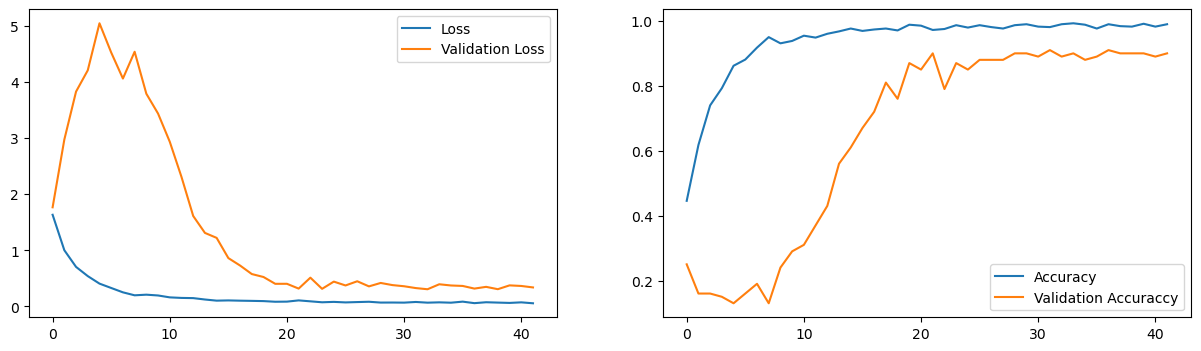

In [39]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['categorical_accuracy'] 
val_acc = history.history['val_categorical_accuracy']

plot_model(loss,val_loss,acc,val_acc)

Observations 

 - Model 3 demonstrated a steady increase in training accuracy, peaking at an impressive 99.71%
 
 - The validation accuracy showed a gradual improvement, reaching its highest at 92.00% in epoch 43.
 
 - As with the previous models, there's a notable gap between training and validation accuracy, suggesting overfitting issues.
 
 - The learning rate was reduced multiple times to improve learning efficiency, and the training was stopped early at epoch 43, indicating no further significant improvement was being made.
 

Model 3 achieved a higher peak in validation accuracy (92.00%) compared to both Model 1 (84.17%) and Model 2 (86.00%), indicating better generalization.

Like Model 2, Model 3 also reached a high training accuracy (over 99%), but it did so while maintaining a slightly better balance with its validation accuracy.

All three models showed signs of overfitting, but Model 3 managed to keep a slightly closer gap between training and validation accuracies.

Model 3 seems to have the best overall performance among the three in terms of balancing high training accuracy with reasonably high validation accuracy, suggesting more effective learning or possibly a more suitable model architecture for the given task.


Based on the above models , lets try 1 more model picking what best seems to work , We will be keeping frames as 30 , batch size as 20 but increase the image size to 150 x 150. Lets see how it performs

### Model 4  Conv3d - Batch Size -20, Image Size (150 x 150 ) , 30 Frames

In [38]:
model_number = 4
batch_size = 20
imageHeight = 150
imageWidth = 150
framesToSample = 30
num_epochs = 50
rgbChannels = 3
input_shape = (framesToSample, imageWidth, imageHeight, rgbChannels)
num_classes = 5 

In [39]:
model=create_model(input_shape, num_classes,128)
optimiser = optimizers.Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
callbacks_list = set_callbacks(model_number,True,True,True,True,'val_categorical_accuracy'); 


In [40]:
train_data_generator = VideoDataGenerator(train_path,train_doc, batch_size, imageHeight, imageWidth, framesToSample)
val_data_generator = VideoDataGenerator(val_path,val_doc, batch_size, imageHeight, imageWidth, framesToSample)

# Use the generator method of the instances to get the generators
train_generator = train_data_generator.generator()
val_generator = val_data_generator.generator()


In [41]:
steps_per_epoch ,validation_steps = get_sequence(train_doc,val_doc,batch_size,num_epochs)

training sequences = 663
validation sequences = 100
epochs = 50
validation_steps 5
steps_per_epoch 34


In [42]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 150, 150, 16   1312      
                             )                                   
                                                                 
 activation_12 (Activation)  (None, 30, 150, 150, 16   0         
                             )                                   
                                                                 
 batch_normalization_18 (Ba  (None, 30, 150, 150, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 15, 75, 75, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 75, 75, 32)   

In [43]:
history=model.fit(train_generator, epochs=num_epochs, verbose=1,steps_per_epoch=steps_per_epoch,   
                    callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0
                   )

Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 1.7051 - categorical_accuracy: 0.4044 
Epoch 1: saving model to models/model-number-4/models-model_init-4_2023-11-1111_13_28.838639\model-00001-1.70515-0.40441-1.66511-0.22000.h5

Epoch 1: val_categorical_accuracy improved from -inf to 0.22000, saving model to models/model-number-4\best_model.h5
34/34 [==============================] - 502s 15s/step - loss: 1.7051 - categorical_accuracy: 0.4044 - val_loss: 1.6651 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 0.9782 - categorical_accuracy: 0.6471 
Epoch 2: saving model to models/model-number-4/models-model_init-4_2023-11-1111_13_28.838639\model-00002-0.97818-0.64706-3.05248-0.21000.h5

Epoch 2: val_categorical_accuracy did not improve from 0.22000
34/34 [==============================] - 497s 15s/step - loss: 0.9782 - categorical_accuracy: 0.6471 - val_loss: 3.0525 - val_categorical_accuracy: 0.2100 -


Epoch 17: val_categorical_accuracy did not improve from 0.66000

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
34/34 [==============================] - 441s 13s/step - loss: 0.2421 - categorical_accuracy: 0.9235 - val_loss: 47.1204 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 18/50
34/34 [==============================] - ETA: 0s - loss: 0.5750 - categorical_accuracy: 0.8044 
Epoch 18: saving model to models/model-number-4/models-model_init-4_2023-11-1111_13_28.838639\model-00018-0.57501-0.80441-8.67461-0.26000.h5

Epoch 18: val_categorical_accuracy did not improve from 0.66000
34/34 [==============================] - 437s 13s/step - loss: 0.5750 - categorical_accuracy: 0.8044 - val_loss: 8.6746 - val_categorical_accuracy: 0.2600 - lr: 2.0000e-04
Epoch 19/50
34/34 [==============================] - ETA: 0s - loss: 0.2214 - categorical_accuracy: 0.9162 
Epoch 19: saving model to models/model-number-4/models-model_init-4_2023-11-1111_13_28.838639


Epoch 33: val_categorical_accuracy did not improve from 0.83000
34/34 [==============================] - 431s 13s/step - loss: 0.0449 - categorical_accuracy: 0.9926 - val_loss: 0.6618 - val_categorical_accuracy: 0.7400 - lr: 1.6000e-06
Epoch 33: early stopping


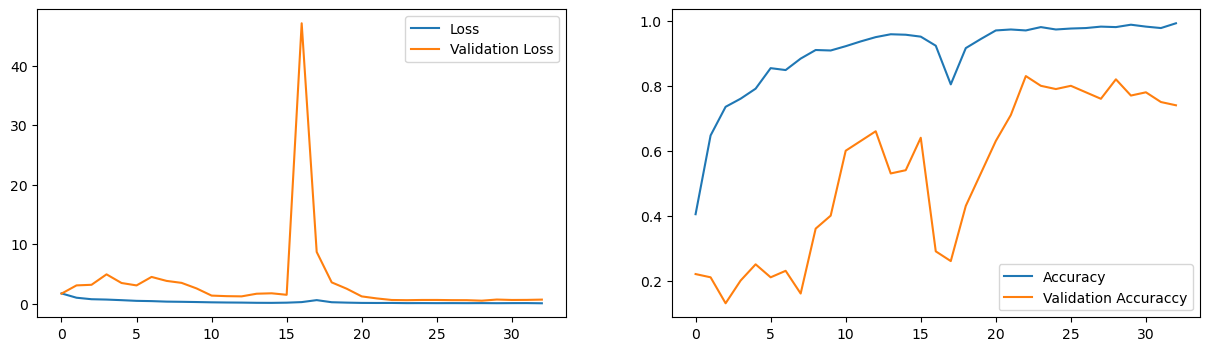

In [44]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['categorical_accuracy'] 
val_acc = history.history['val_categorical_accuracy']

plot_model(loss,val_loss,acc,val_acc)

Observations 
 - 

Based on the performance metrics of the previous models, it's observed that Model 3 outperforms the others with a validation accuracy of 91%, suggesting a good balance between model complexity and ability to generalize. However, there is still a discrepancy between training and validation accuracy, indicating potential overfitting.

For further experimentation, we would be changes below : 
a) Image Size - Images that are too large fails to perform well as compare to others but the image size should be good enough to capture the information. We will choose it to be 110 x 110 

b)Batch Size to be kept as 22  

c) Increasing the density of the neurons in the dense layers to 136 could potentially capture more complex patterns without significantly increasing the risk of overfitting. 



In [46]:
model_number = 5
batch_size = 22
imageHeight = 110
imageWidth = 110
framesToSample = 30
num_epochs = 50
rgbChannels = 3
input_shape = (framesToSample, imageWidth, imageHeight, rgbChannels)
num_classes = 5 
denseNeurons = 136

In [47]:
model=create_model(input_shape, num_classes,denseNeurons)
optimiser = optimizers.Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
callbacks_list = set_callbacks(model_number,True,True,True,True,'val_categorical_accuracy'); 


In [48]:
train_data_generator = VideoDataGenerator(train_path,train_doc, batch_size, imageHeight, imageWidth, framesToSample)
val_data_generator = VideoDataGenerator(val_path,val_doc, batch_size, imageHeight, imageWidth, framesToSample)

# Use the generator method of the instances to get the generators
train_generator = train_data_generator.generator()
val_generator = val_data_generator.generator()


In [49]:
steps_per_epoch ,validation_steps = get_sequence(train_doc,val_doc,batch_size,num_epochs)

training sequences = 663
validation sequences = 100
epochs = 50
validation_steps 5
steps_per_epoch 31


In [50]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 30, 110, 110, 16   1312      
                             )                                   
                                                                 
 activation_16 (Activation)  (None, 30, 110, 110, 16   0         
                             )                                   
                                                                 
 batch_normalization_24 (Ba  (None, 30, 110, 110, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_16 (MaxPooli  (None, 15, 55, 55, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_17 (Conv3D)          (None, 15, 55, 55, 32)   

In [51]:
history=model.fit(train_generator, epochs=num_epochs, verbose=1,steps_per_epoch=steps_per_epoch,   
                    callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0
                   )

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 1.7492 - categorical_accuracy: 0.3886
Epoch 1: saving model to models/model-number-5/models-model_init-5_2023-11-1116_09_02.108394\model-00001-1.74921-0.38856-1.93527-0.24545.h5

Epoch 1: val_categorical_accuracy improved from -inf to 0.24545, saving model to models/model-number-5\best_model.h5
31/31 [==============================] - 227s 7s/step - loss: 1.7492 - categorical_accuracy: 0.3886 - val_loss: 1.9353 - val_categorical_accuracy: 0.2455 - lr: 0.0010
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 1.0685 - categorical_accuracy: 0.5850
Epoch 2: saving model to models/model-number-5/models-model_init-5_2023-11-1116_09_02.108394\model-00002-1.06847-0.58504-1.89860-0.05455.h5

Epoch 2: val_categorical_accuracy did not improve from 0.24545
31/31 [==============================] - 224s 7s/step - loss: 1.0685 - categorical_accuracy: 0.5850 - val_loss: 1.8986 - val_categorical_accuracy: 0.0545 - lr:


Epoch 33: val_categorical_accuracy did not improve from 0.85455
31/31 [==============================] - 233s 8s/step - loss: 0.0760 - categorical_accuracy: 0.9868 - val_loss: 0.3443 - val_categorical_accuracy: 0.6000 - lr: 1.6000e-06
Epoch 34/50
31/31 [==============================] - ETA: 0s - loss: 0.0699 - categorical_accuracy: 0.9868
Epoch 34: saving model to models/model-number-5/models-model_init-5_2023-11-1116_09_02.108394\model-00034-0.06988-0.98680-0.11449-0.37273.h5

Epoch 34: val_categorical_accuracy did not improve from 0.85455

Epoch 34: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
31/31 [==============================] - 235s 8s/step - loss: 0.0699 - categorical_accuracy: 0.9868 - val_loss: 0.1145 - val_categorical_accuracy: 0.3727 - lr: 1.6000e-06
Epoch 35/50
31/31 [==============================] - ETA: 0s - loss: 0.0683 - categorical_accuracy: 0.9868
Epoch 35: saving model to models/model-number-5/models-model_init-5_2023-11-1116_09_02.108394\m

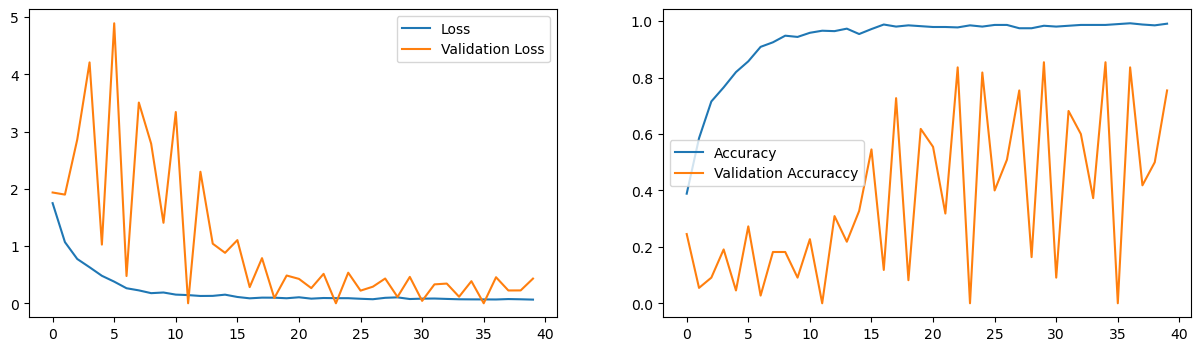

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['categorical_accuracy'] 
val_acc = history.history['val_categorical_accuracy']

plot_model(loss,val_loss,acc,val_acc)

 Observation 
 
  - The training starts with a relatively high categorical accuracy of 38.86% which improves consistently over epochs, reaching a high of 99.12%. This indicates that the model is learning and improving its performance on the training set over time.
  
   - The validation categorical accuracy starts at 24.55%, indicating the model's initial performance on unseen data. It experiences a significant fluctuation and peaks at 85.455% before dropping. This peak is lower than that of Model 3, which reached 91%.
   
   - Model 5 shows signs of overfitting, as evidenced by the high training accuracy compared to the validation accuracy. Overfitting is further suggested by the validation accuracy's fluctuations and the fact that the model's performance on the validation set does not improve consistently in line with the training accuracy.
   
   - Early stopping is triggered at epoch 40, suggesting that the model's performance on the validation set was not improving for a number of epochs, which is a safeguard to prevent overfitting and unnecessary computations.

This model shows a strong start in training accuracy, quickly reaching above 98% accuracy by the 16th epoch. However, its validation accuracy is quite volatile, peaking at 85.455% on the 30th epoch and showing significant fluctuations throughout the training process. This suggests that the model may be overfitting to the training data and not generalizing well to the validation set.

Model 3 is superior in terms of validation accuracy and stability throughout training epochs, making it a better model in terms of generalization to new data. Model 5, despite its high training accuracy, does not generalize as effectively as evidenced by its lower and more volatile validation accuracy. 

### Model 6 ( CNN- LSTM )

In [30]:
model_number = 6
batch_size = 20
imageHeight = 120
imageWidth = 120
framesToSample = 30
num_epochs = 30
rgbChannels = 3
input_shape = (framesToSample, imageWidth, imageHeight, rgbChannels)
num_classes = 5 
lstm_cells=64
dense_neurons = 64
dropout = 0.50

In [37]:
    model = Sequential()

#     model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
#                               input_shape=input_shape))
#     model.add(TimeDistributed(BatchNormalization()))
#     model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'),
                          input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

#     model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
#     model.add(TimeDistributed(BatchNormalization()))
#     model.add(TimeDistributed(MaxPooling2D((2, 2))))

    #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
    # model.add(TimeDistributed(BatchNormalization()))
    # model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))


    model.add(LSTM(lstm_cells))
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(num_classes, activation='softmax'))

In [38]:
optimiser = optimizers.Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
callbacks_list = set_callbacks(model_number,True,True,True,True,'val_categorical_accuracy'); 

In [39]:
train_data_generator = VideoDataGenerator(train_path,train_doc, batch_size, imageHeight, imageWidth, framesToSample)
val_data_generator = VideoDataGenerator(val_path,val_doc, batch_size, imageHeight, imageWidth, framesToSample)

# Use the generator method of the instances to get the generators
train_generator = train_data_generator.generator()
val_generator = val_data_generator.generator()


In [40]:
steps_per_epoch ,validation_steps = get_sequence(train_doc,val_doc,batch_size,num_epochs)

training sequences = 663
validation sequences = 100
epochs = 30
validation_steps 5
steps_per_epoch 34


In [41]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_56 (TimeD  (None, 30, 120, 120, 32   896       
 istributed)                 )                                   
                                                                 
 time_distributed_57 (TimeD  (None, 30, 120, 120, 32   128       
 istributed)                 )                                   
                                                                 
 time_distributed_58 (TimeD  (None, 30, 60, 60, 32)    0         
 istributed)                                                     
                                                                 
 time_distributed_59 (TimeD  (None, 30, 60, 60, 64)    18496     
 istributed)                                                     
                                                                 
 time_distributed_60 (TimeD  (None, 30, 60, 60, 64)   

In [42]:
history=model.fit(train_generator, epochs=num_epochs, verbose=1,steps_per_epoch=steps_per_epoch,   
                    callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0
                   )

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.7712 - categorical_accuracy: 0.1853 
Epoch 1: saving model to models/model-number-6/models-model_init-6_2023-11-1209_53_30.057342\model-00001-1.77117-0.18529-1.66580-0.20000.h5

Epoch 1: val_categorical_accuracy improved from -inf to 0.20000, saving model to models/model-number-6\best_model.h5
34/34 [==============================] - 648s 19s/step - loss: 1.7712 - categorical_accuracy: 0.1853 - val_loss: 1.6658 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.6895 - categorical_accuracy: 0.2103 
Epoch 2: saving model to models/model-number-6/models-model_init-6_2023-11-1209_53_30.057342\model-00002-1.68951-0.21029-1.67783-0.19000.h5

Epoch 2: val_categorical_accuracy did not improve from 0.20000
34/34 [==============================] - 643s 19s/step - loss: 1.6895 - categorical_accuracy: 0.2103 - val_loss: 1.6778 - val_categorical_accuracy: 0.1900 -


Epoch 17: val_categorical_accuracy did not improve from 0.47000
34/34 [==============================] - 151s 4s/step - loss: 1.4058 - categorical_accuracy: 0.4118 - val_loss: 1.3362 - val_categorical_accuracy: 0.4600 - lr: 2.0000e-04
Epoch 18/30
34/34 [==============================] - ETA: 0s - loss: 1.3105 - categorical_accuracy: 0.4191
Epoch 18: saving model to models/model-number-6/models-model_init-6_2023-11-1209_53_30.057342\model-00018-1.31050-0.41912-1.42368-0.30000.h5

Epoch 18: val_categorical_accuracy did not improve from 0.47000
34/34 [==============================] - 148s 4s/step - loss: 1.3105 - categorical_accuracy: 0.4191 - val_loss: 1.4237 - val_categorical_accuracy: 0.3000 - lr: 2.0000e-04
Epoch 19/30
34/34 [==============================] - ETA: 0s - loss: 1.3646 - categorical_accuracy: 0.4132
Epoch 19: saving model to models/model-number-6/models-model_init-6_2023-11-1209_53_30.057342\model-00019-1.36463-0.41324-1.24512-0.46000.h5

Epoch 19: val_categorical_accur

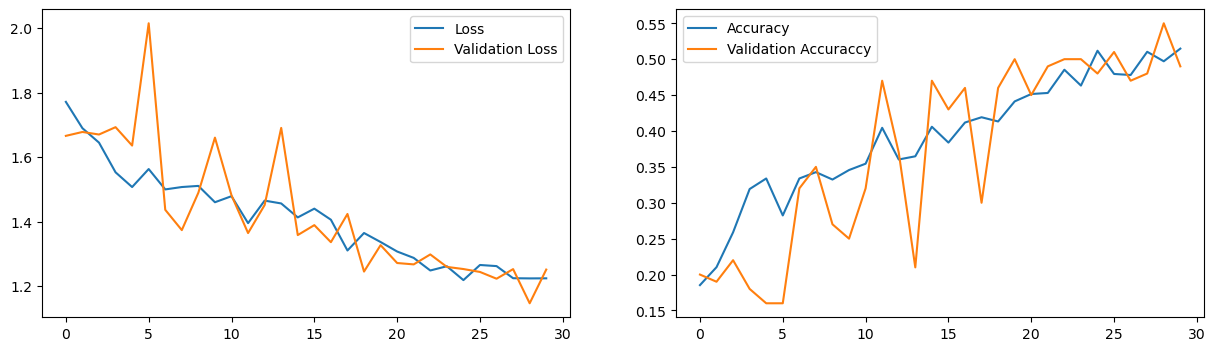

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['categorical_accuracy'] 
val_acc = history.history['val_categorical_accuracy']

plot_model(loss,val_loss,acc,val_acc)

### Model 7 ( Transfer Learning Using ResNet50 )

In [41]:
model_number = 7
batch_size = 20
imageHeight = 120
imageWidth = 120
framesToSample = 30
num_epochs = 30
rgbChannels = 3
input_shape = (framesToSample, imageWidth, imageHeight, rgbChannels)
num_classes = 5 
lstm_cells=64
dense_neurons = 64
dropout = 0.50

In [73]:
from tensorflow.keras.applications import ResNet50

resnet_transfer = ResNet50(weights='imagenet', include_top=False) #False means that we are not taking the output layers

def model_transfer(input_shape, num_classes, dense_neurons=64, dropout=0.25):
    model = Sequential()
    model.add(TimeDistributed(resnet_transfer, input_shape=input_shape))

    for layer in model.layers:
        layer.trainable = False

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(TimeDistributed(Dense(dense_neurons, activation='relu')))
    model.add(TimeDistributed(Dropout(dropout)))


    model.add(Flatten())  

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [79]:
model = model_transfer(input_shape,5)

In [80]:
callbacks_list = set_callbacks(model_number,True,True,True,True,'val_categorical_accuracy'); 

In [81]:
train_data_generator = VideoDataGenerator(train_path,train_doc, batch_size, imageHeight, imageWidth, framesToSample)
val_data_generator = VideoDataGenerator(val_path,val_doc, batch_size, imageHeight, imageWidth, framesToSample)

# Use the generator method of the instances to get the generators
train_generator = train_data_generator.generator()
val_generator = val_data_generator.generator()


In [82]:
steps_per_epoch ,validation_steps = get_sequence(train_doc,val_doc,batch_size,num_epochs)

training sequences = 663
validation sequences = 100
epochs = 30
validation_steps 5
steps_per_epoch 34


In [83]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_96 (TimeD  (None, 30, 4, 4, 2048)    23587712  
 istributed)                                                     
                                                                 
 time_distributed_97 (TimeD  (None, 30, 4, 4, 2048)    8192      
 istributed)                                                     
                                                                 
 time_distributed_98 (TimeD  (None, 30, 2, 2, 2048)    0         
 istributed)                                                     
                                                                 
 time_distributed_99 (TimeD  (None, 30, 8192)          0         
 istributed)                                                     
                                                                 
 time_distributed_100 (Time  (None, 30, 64)          

In [84]:
history=model.fit(train_generator, epochs=num_epochs, verbose=1,steps_per_epoch=steps_per_epoch,   
                    callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0
                   )

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.1448 - categorical_accuracy: 0.2162
Epoch 1: saving model to models/model-number-6/models-model_init-6_2023-11-1120_09_56.082332\model-00001-2.14479-0.21618-1.58634-0.24000.h5

Epoch 1: val_categorical_accuracy improved from -inf to 0.24000, saving model to models/model-number-6\best_model.h5
34/34 [==============================] - 149s 4s/step - loss: 2.1448 - categorical_accuracy: 0.2162 - val_loss: 1.5863 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5199 - categorical_accuracy: 0.2897
Epoch 2: saving model to models/model-number-6/models-model_init-6_2023-11-1120_09_56.082332\model-00002-1.51992-0.28971-1.59232-0.32000.h5

Epoch 2: val_categorical_accuracy improved from 0.24000 to 0.32000, saving model to models/model-number-6\best_model.h5
34/34 [==============================] - 139s 4s/step - loss: 1.5199 - categorical_accuracy: 0.2897 - 

Epoch 17/30
34/34 [==============================] - ETA: 0s - loss: 0.9323 - categorical_accuracy: 0.6176
Epoch 17: saving model to models/model-number-6/models-model_init-6_2023-11-1120_09_56.082332\model-00017-0.93229-0.61765-1.05077-0.52000.h5

Epoch 17: val_categorical_accuracy did not improve from 0.59000
34/34 [==============================] - 133s 4s/step - loss: 0.9323 - categorical_accuracy: 0.6176 - val_loss: 1.0508 - val_categorical_accuracy: 0.5200 - lr: 4.0000e-05
Epoch 18/30
34/34 [==============================] - ETA: 0s - loss: 0.9381 - categorical_accuracy: 0.6132
Epoch 18: saving model to models/model-number-6/models-model_init-6_2023-11-1120_09_56.082332\model-00018-0.93809-0.61324-0.97452-0.60000.h5

Epoch 18: val_categorical_accuracy improved from 0.59000 to 0.60000, saving model to models/model-number-6\best_model.h5
34/34 [==============================] - 134s 4s/step - loss: 0.9381 - categorical_accuracy: 0.6132 - val_loss: 0.9745 - val_categorical_accuracy:

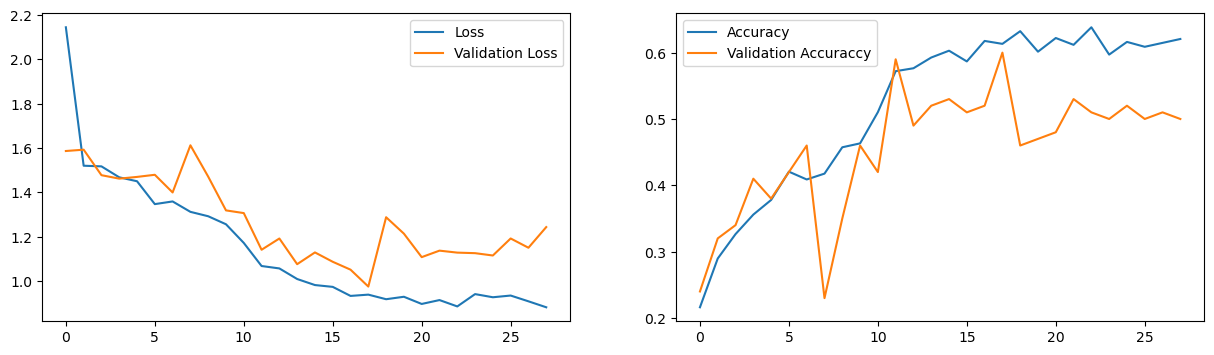

In [85]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['categorical_accuracy'] 
val_acc = history.history['val_categorical_accuracy']

plot_model(loss,val_loss,acc,val_acc)

### Model 8

In [58]:
model_number = 8
batch_size = 20
imageHeight = 100
imageWidth = 100
framesToSample = 30
num_epochs = 30
rgbChannels = 3
input_shape = (framesToSample, imageWidth, imageHeight, rgbChannels)
num_classes = 5 
lstm_cells=64
dense_neurons = 64
dropout = 0.50

In [59]:
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dense, Dropout, GRU, LSTM
from keras import optimizers

def GRU_LSTM_model(input_shape, num_classes, lstm_cells=64, dense_neurons=64, dropout=0.5):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    # Combine GRU and LSTM layers
    model.add(GRU(lstm_cells, return_sequences=True))
    model.add(LSTM(lstm_cells))
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons, activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(num_classes, activation='softmax'))

    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [60]:
model = GRU_LSTM_model(input_shape,num_classes)

In [61]:
callbacks_list = set_callbacks(model_number,True,True,True,True,'val_categorical_accuracy'); 

In [62]:
train_data_generator = VideoDataGenerator(train_path,train_doc, batch_size, imageHeight, imageWidth, framesToSample)
val_data_generator = VideoDataGenerator(val_path,val_doc, batch_size, imageHeight, imageWidth, framesToSample)

# Use the generator method of the instances to get the generators
train_generator = train_data_generator.generator()
val_generator = val_data_generator.generator()


In [63]:
steps_per_epoch ,validation_steps = get_sequence(train_doc,val_doc,batch_size,num_epochs)

training sequences = 663
validation sequences = 100
epochs = 30
validation_steps 5
steps_per_epoch 34


In [64]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeD  (None, 30, 100, 100, 16   448       
 istributed)                 )                                   
                                                                 
 time_distributed_33 (TimeD  (None, 30, 100, 100, 16   64        
 istributed)                 )                                   
                                                                 
 time_distributed_34 (TimeD  (None, 30, 50, 50, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_35 (TimeD  (None, 30, 50, 50, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_36 (TimeD  (None, 30, 50, 50, 32)   

In [65]:
history=model.fit(train_generator, epochs=num_epochs, verbose=1,steps_per_epoch=steps_per_epoch,   
                    callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0
                   )

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.6008 - categorical_accuracy: 0.2559
Epoch 1: saving model to models/model-number-8/models-model_init-8_2023-11-1321_12_28.286070\model-00001-1.60082-0.25588-1.63381-0.29000.h5

Epoch 1: val_categorical_accuracy improved from -inf to 0.29000, saving model to models/model-number-8\best_model.h5
34/34 [==============================] - 68s 2s/step - loss: 1.6008 - categorical_accuracy: 0.2559 - val_loss: 1.6338 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4410 - categorical_accuracy: 0.3588
Epoch 2: saving model to models/model-number-8/models-model_init-8_2023-11-1321_12_28.286070\model-00002-1.44099-0.35882-1.76350-0.19000.h5

Epoch 2: val_categorical_accuracy did not improve from 0.29000
34/34 [==============================] - 70s 2s/step - loss: 1.4410 - categorical_accuracy: 0.3588 - val_loss: 1.7635 - val_categorical_accuracy: 0.1900 - lr: 0

Epoch 17/30
34/34 [==============================] - ETA: 0s - loss: 0.2637 - categorical_accuracy: 0.9353
Epoch 17: saving model to models/model-number-8/models-model_init-8_2023-11-1321_12_28.286070\model-00017-0.26373-0.93529-0.88838-0.76000.h5

Epoch 17: val_categorical_accuracy improved from 0.71000 to 0.76000, saving model to models/model-number-8\best_model.h5
34/34 [==============================] - 60s 2s/step - loss: 0.2637 - categorical_accuracy: 0.9353 - val_loss: 0.8884 - val_categorical_accuracy: 0.7600 - lr: 2.0000e-04
Epoch 18/30
34/34 [==============================] - ETA: 0s - loss: 0.2420 - categorical_accuracy: 0.9500
Epoch 18: saving model to models/model-number-8/models-model_init-8_2023-11-1321_12_28.286070\model-00018-0.24201-0.95000-0.95145-0.75000.h5

Epoch 18: val_categorical_accuracy did not improve from 0.76000
34/34 [==============================] - 60s 2s/step - loss: 0.2420 - categorical_accuracy: 0.9500 - val_loss: 0.9514 - val_categorical_accuracy: 0

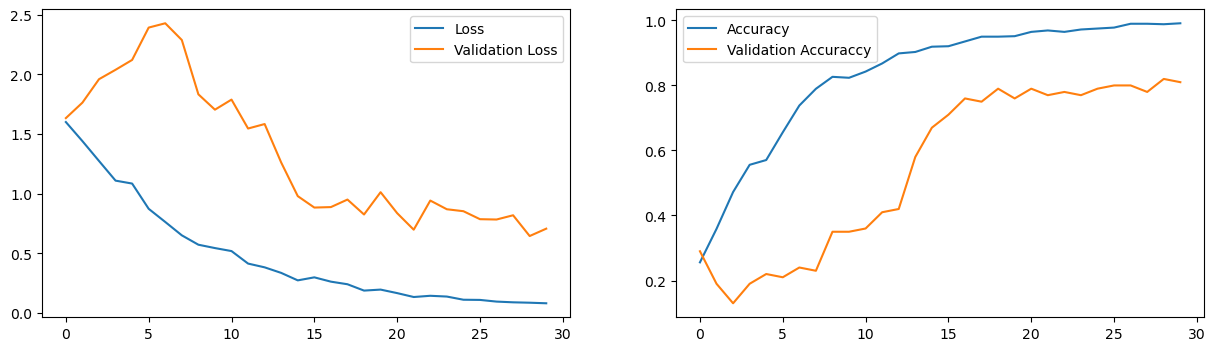

In [66]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['categorical_accuracy'] 
val_acc = history.history['val_categorical_accuracy']

plot_model(loss,val_loss,acc,val_acc)